In [92]:
import numpy as np
import sys
import os
import re
import pandas as pd
import pickle
from tabulate import tabulate
import logging
import ldc.io.hdf5 as h5io
from ldc.lisa.noise import get_noise_model  
                                                                                                                                                               
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import torch


import seaborn as sns
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath("../src"))
from model import MultiTaskClassifier
logging.getLogger("seaborn").setLevel(logging.WARNING)
%matplotlib inline

In [99]:
test_set_path = "../data/test_set/test_set_seed_1.csv"
test_df = pd.read_csv(test_set_path)
print("Test set shape:", test_df.shape)


X_test = test_df.drop(columns=["Class", "Model"])
y_test_binary = test_df["Class"].values  # Binary labels (0 or 1)
y_test_model = test_df["Model_enc"].values    # Multi-class labels (encoded as numbers)
y_test_model_decoded = test_df['Model'].values

loss_history_path = "../models/train_loss_history_multitask.csv"
loss_history = pd.read_csv(loss_history_path)

Test set shape: (33746, 8)


In [56]:
test_df

,Frequency,Amplitude,FrequencyDerivative,SNR,Eccentricity,Class,Model_enc,Model
0,0.294818,-0.099386,-0.029212,-0.002712,-0.062896,0,4,Model 1.4
1,-1.172694,0.270786,-0.051007,-0.289580,-0.062896,0,2,Model 1.2
2,-0.575368,-0.298423,-0.046701,-0.296915,-0.062896,0,2,Model 1.2
3,0.347390,-0.109472,-0.026726,-0.029007,-0.062896,0,3,Model 1.3
4,0.875256,-0.425936,-0.036010,-0.490459,12.846370,1,3,Model 1.3
...,...,...,...,...,...,...,...,...
33741,-0.311958,-0.195560,-0.043774,-0.343246,-0.062896,0,3,Model 1.3
33742,-0.686157,0.179964,-0.050143,-0.059952,-0.062896,0,0,Model 1.0
33743,-0.876223,-0.119325,-0.048471,-0.263259,-0.062896,0,4,Model 1.4
33744,-0.252706,-0.319251,-0.047128,-0.457750,-0.062896,0,4,Model 1.4


# Test Set Details

2025-03-05 18:56:38,557 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-03-05 18:56:38,594 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


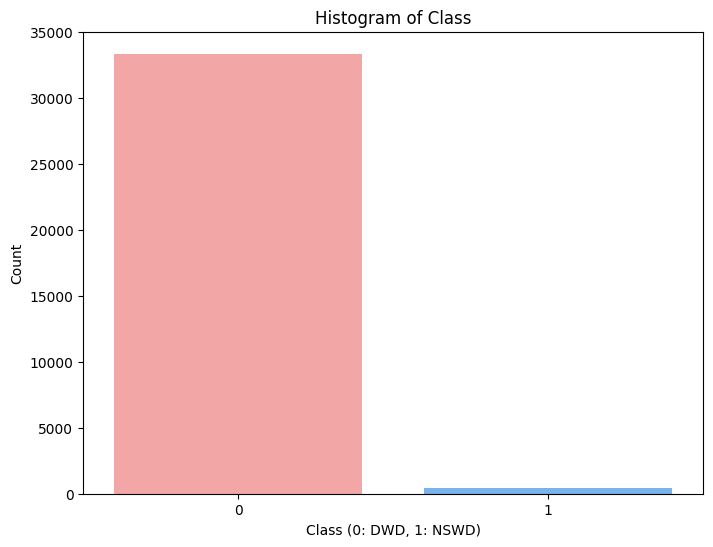

In [93]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x="Class", hue="Class", data=test_df, palette=["#ff9999", "#66b3ff"])

plt.title("Histogram of Class")
plt.xlabel("Class (0: DWD, 1: NSWD)")
plt.ylabel("Count")
plt.show()

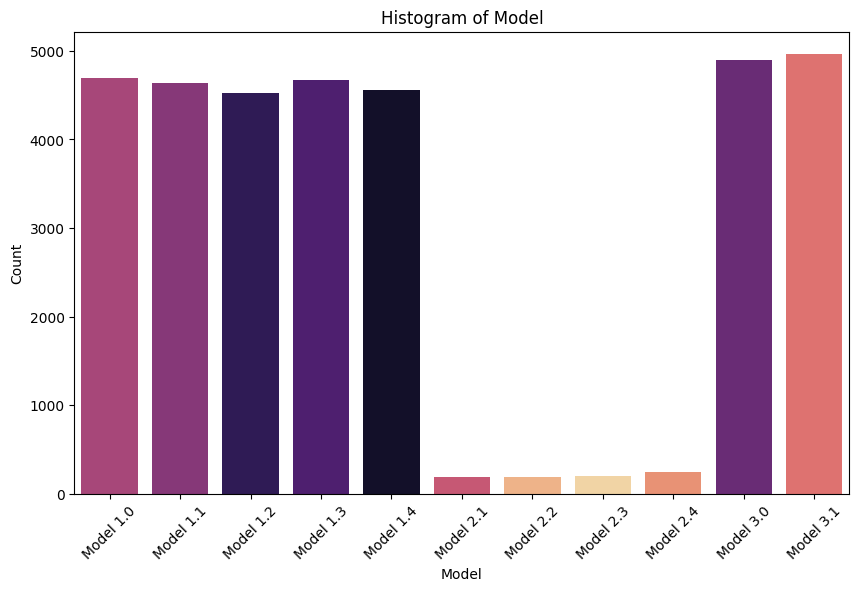

In [98]:
plt.figure(figsize=(10, 6))

ax = sns.countplot(x="Model", hue="Model", data=test_df, order=order, palette=sns.color_palette("magma", n_colors=len(order)))
plt.title("Histogram of Model")
plt.xlabel("Model")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

In [79]:
# Frequency table for Class
class_freq = test_df["Class"].value_counts().sort_index()
class_freq_df = class_freq.reset_index().rename(columns={"index": "Class", "Class": "Frequency"})
print("Frequency table for Class:")
print(tabulate(class_freq_df, headers="keys", tablefmt="github"))

# Frequency table for Model
model_freq = test_df["Model"].value_counts().sort_index()
model_freq_df = model_freq.reset_index().rename(columns={"index": "Model", "Model": "Frequency"})
print("\nFrequency table for Model:")
print(tabulate(model_freq_df, headers="keys", tablefmt="github"))

Frequency table for Class:
|    |   Frequency |   count |
|----|-------------|---------|
|  0 |           0 |   33343 |
|  1 |           1 |     403 |

Frequency table for Model:
|    | Frequency   |   count |
|----|-------------|---------|
|  0 | Model 1.0   |    4690 |
|  1 | Model 1.1   |    4632 |
|  2 | Model 1.2   |    4520 |
|  3 | Model 1.3   |    4673 |
|  4 | Model 1.4   |    4563 |
|  5 | Model 2.1   |     183 |
|  6 | Model 2.2   |     183 |
|  7 | Model 2.3   |     194 |
|  8 | Model 2.4   |     245 |
|  9 | Model 3.0   |    4893 |
| 10 | Model 3.1   |    4970 |


In [17]:
input_dim = X_test.shape[1]

num_model_classes = len(np.unique(y_test_model))
model_save_path = "../models/multi_task_classifier.pth"


model_instance = MultiTaskClassifier(input_dim, num_model_classes)
model_instance.load_state_dict(torch.load(model_save_path, map_location=torch.device("cpu")))
model_instance.eval()
print("Model loaded.")

Model loaded.


# Binary Class 

In [18]:
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)

with torch.no_grad():
    binary_preds, model_logits = model_instance(X_test_tensor)
    
binary_preds = binary_preds.squeeze().numpy()   

model_preds = torch.argmax(model_logits, dim=1).numpy() #highest confidence for the class

# Display a few predictions
print("Binary predictions (first 10):", binary_preds[:10])
print("Multi-class predictions (first 10):", model_preds[:10])

Binary predictions (first 10): [5.1759428e-04 2.4654379e-02 1.1598362e-03 4.9996685e-04 1.0000000e+00
 3.6861014e-11 8.3382672e-04 2.4137357e-02 3.0787749e-04 2.1285111e-11]
Multi-class predictions (first 10): [ 2  4  2  2  3  1  2  4  2 10]


In [31]:
threshold = 0.5
binary_pred_labels = (binary_preds >= threshold).astype(int)

accuracy_binary = accuracy_score(y_test_binary, binary_pred_labels)
sensitivity = recall_score(y_test_binary, binary_pred_labels, pos_label=1)  # True positive rate
specificity = recall_score(y_test_binary, binary_pred_labels, pos_label=0)  # True negative rate

print("Binary Classification Metrics:")
print(f"Accuracy: {accuracy_binary:.4f}")
print(f"Sensitivity (Recall for class 1): {sensitivity:.4f}")
print(f"Specificity (Recall for class 0): {specificity:.4f}")


Binary Classification Metrics:
Accuracy: 0.9956
Sensitivity (Recall for class 1): 0.6352
Specificity (Recall for class 0): 1.0000


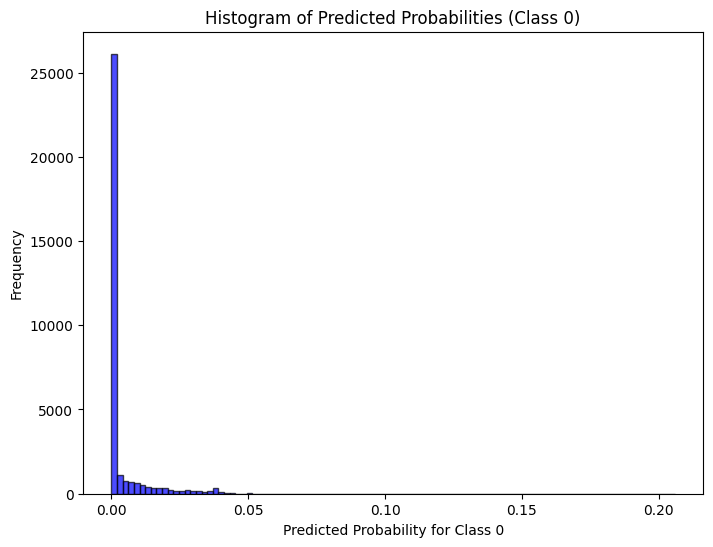

In [41]:
# Filter predicted probabilities by ground truth
pred_probs_gt0 = binary_preds[y_test_binary == 0]
pred_probs_gt1 = binary_preds[y_test_binary == 1]

# Histogram for ground truth = class 0
plt.figure(figsize=(8,6))
plt.hist(pred_probs_gt0, bins=100, color='blue', alpha=0.7, edgecolor='black')
plt.title("Histogram of Predicted Probabilities (Class 0)")
plt.xlabel("Predicted Probability for Class 0")
plt.ylabel("Frequency")
plt.show()


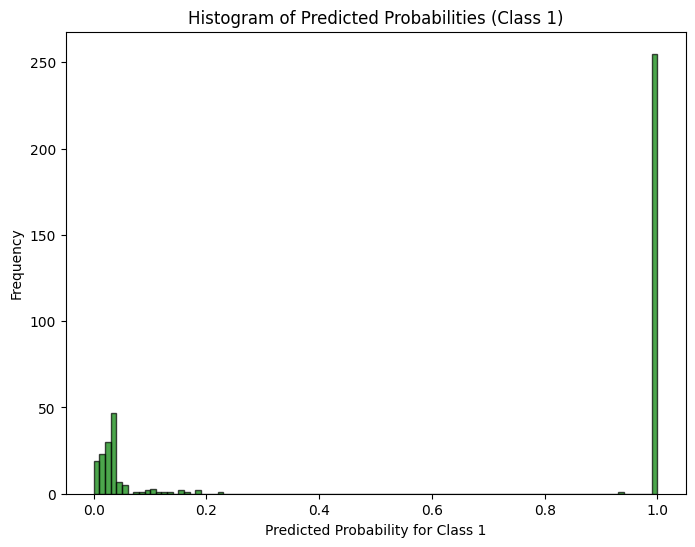

In [42]:
plt.figure(figsize=(8,6))
plt.hist(pred_probs_gt1, bins=100, color='green', alpha=0.7, edgecolor='black')
plt.title("Histogram of Predicted Probabilities (Class 1)")
plt.xlabel("Predicted Probability for Class 1")
plt.ylabel("Frequency")
plt.show()

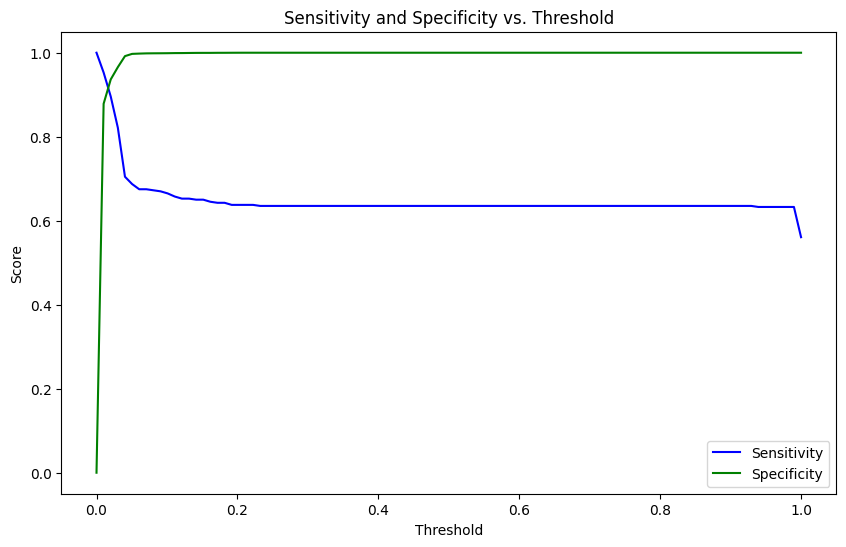

In [48]:
thresholds = np.linspace(0, 1, 100)
sensitivity_list = []
specificity_list = []

for thresh in thresholds:

    y_pred_thresh = (binary_preds >= thresh).astype(int)
    
    # Compute confusion matrix: [ [TN, FP], [FN, TP] ]
    tn, fp, fn, tp = confusion_matrix(y_test_binary, y_pred_thresh).ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity_list.append(sensitivity)
    specificity_list.append(specificity)

# Plot sensitivity and specificity vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, sensitivity_list, label="Sensitivity", color='blue')
plt.plot(thresholds, specificity_list, label="Specificity", color='green')
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Sensitivity and Specificity vs. Threshold")
plt.legend()
plt.show()

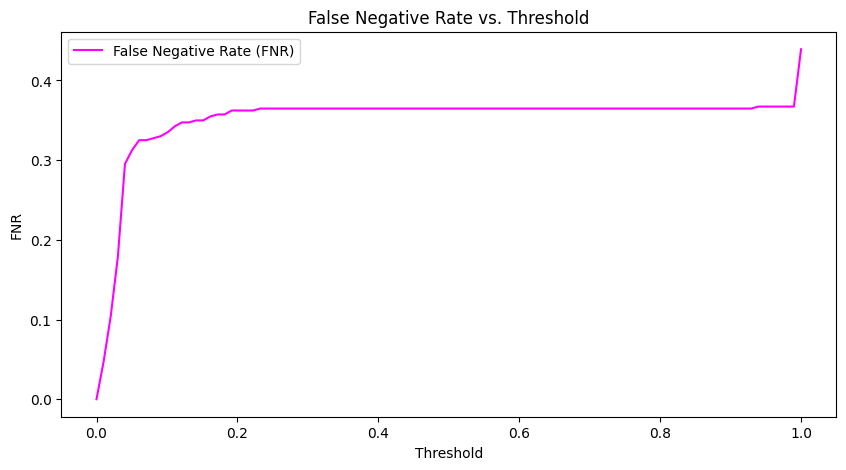

In [70]:
thresholds = np.linspace(0, 1, 100)
fnr_list = []

for t in thresholds:

    preds = (binary_preds >= t).astype(int)
    
    TP = np.sum((preds == 1) & (y_test_binary == 1))
    FN = np.sum((preds == 0) & (y_test_binary == 1))
    
    fnr = FN / (TP + FN) if (TP + FN) > 0 else 0
    fnr_list.append(fnr)


plt.figure(figsize=(10, 5))
plt.plot(thresholds, fnr_list, label="False Negative Rate (FNR)", color="magenta")
plt.xlabel("Threshold")
plt.ylabel("FNR")
plt.title("False Negative Rate vs. Threshold")
plt.legend()
plt.show()

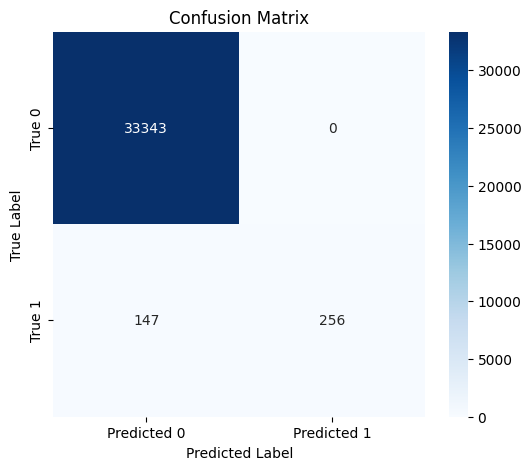

In [27]:
cm = confusion_matrix(y_test_binary, binary_pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=["Predicted 0", "Predicted 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Multiclass analysis

Accuracy: 0.1765


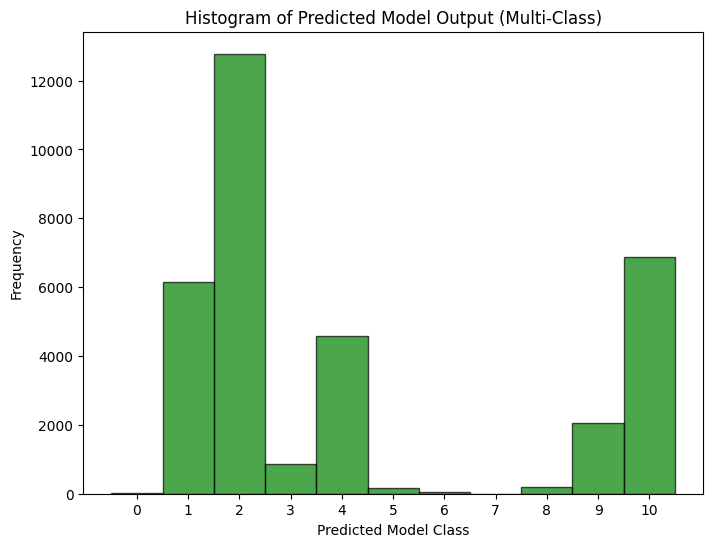

In [50]:

accuracy_model = accuracy_score(y_test_model, model_preds)


print(f"Accuracy: {accuracy_model:.4f}")


plt.figure(figsize=(8,6))

bins = np.arange(num_model_classes + 1) - 0.5
plt.hist(model_preds, bins=bins, color="green", alpha=0.7, edgecolor="black")
plt.xlabel("Predicted Model Class")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Model Output (Multi-Class)")
plt.xticks(range(num_model_classes))
plt.show()

In [67]:
with open(os.path.join("..", "models", "encoders","model_encoder.pkl"), "rb") as f:
    model_encoder = pickle.load(f)

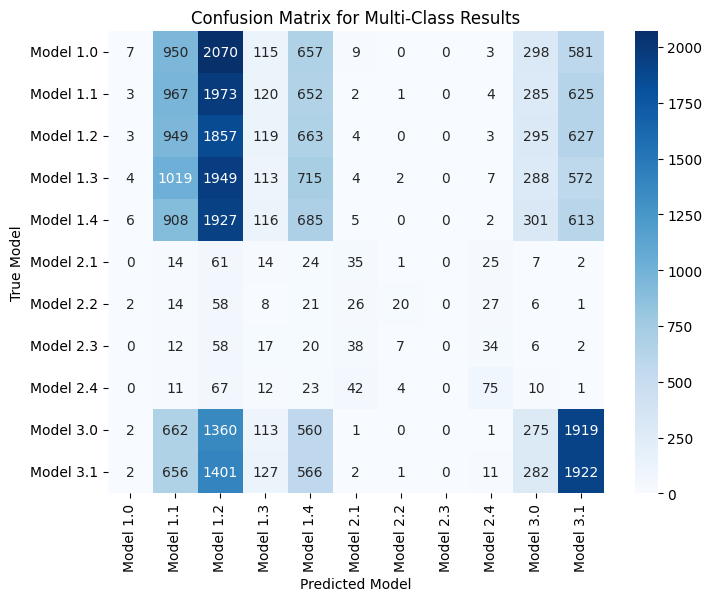

In [68]:
cm_model = confusion_matrix(y_test_model, model_preds)

class_names = list(model_encoder.classes_)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_model, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Model")
plt.ylabel("True Model")
plt.title("Confusion Matrix for Multi-Class Results")
plt.show()

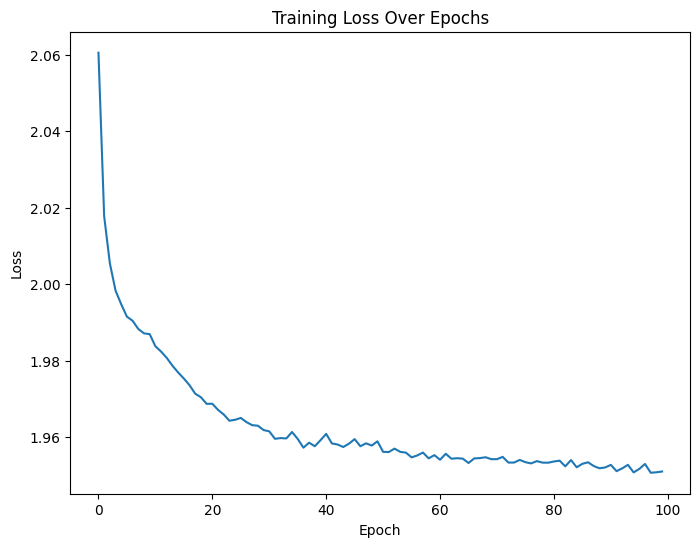

In [24]:
plt.figure(figsize=(8,6))
plt.plot(loss_history["Loss"],  linestyle="-")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

- Validation (done), Network size bigger (done), try data without ecc (done), weights on duplicates (done), can increase the size of dataset (population synthesis). 
Use a baseline classifier to compare with. Try knn. (done) 

Check the salincy of the network (done)

- Increase the dataset by taking Gaussian from the median of the fisher matrix. 
- To address the classification imbalance -> increase the number of points for NSWD? 
- Test the weights out

Sum up probability for Models 1 2 3, Error analysis on baseline model, log transformation for A f_dot and SNR. Resampling and weighting. Figure out model's behaviour.